In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/content/NF-ToN-IoT.csv')

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192.168.1.31,58032,192.168.1.194,80,6,7.00,216,180,4,3,18,9433,1,ddos
1379270,192.168.1.31,58034,192.168.1.194,80,6,7.00,216,180,4,3,18,9221,1,ddos
1379271,192.168.1.31,58036,192.168.1.194,80,6,7.00,216,180,4,3,18,9656,1,ddos
1379272,192.168.1.31,58038,192.168.1.194,80,6,7.00,216,180,4,3,18,10046,1,ddos


In [4]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [6]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [7]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [8]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.18.174.73:63318,52.139.250.253:443,6,91.00,181,165,2,1,24,327,0,Benign
1,172.21.105.22:57442,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0,Benign
2,172.27.67.73:57452,239.255.255.250:15600,17,0.00,63,0,1,0,0,0,0,Benign
3,172.24.40.184:138,192.168.1.255:138,17,10.16,472,0,2,0,0,0,0,Benign
4,172.29.77.5:51989,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,172.16.31.157:58032,192.168.1.194:80,6,7.00,216,180,4,3,18,9433,1,ddos
1379270,172.24.214.65:58034,192.168.1.194:80,6,7.00,216,180,4,3,18,9221,1,ddos
1379271,172.21.120.36:58036,192.168.1.194:80,6,7.00,216,180,4,3,18,9656,1,ddos
1379272,172.28.23.110:58038,192.168.1.194:80,6,7.00,216,180,4,3,18,10046,1,ddos


In [9]:
data.drop(columns=['Label'],inplace = True)

In [10]:
data.rename(columns={"Attack": "label"},inplace = True)

In [11]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [12]:
label = data.label

In [13]:
data.drop(columns=['label'],inplace = True)

In [14]:
scaler = StandardScaler()

In [15]:
data =  pd.concat([data, label], axis=1)

In [16]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.18.174.73:63318,52.139.250.253:443,6,91.00,181,165,2,1,24,327,0
1,172.21.105.22:57442,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0
2,172.27.67.73:57452,239.255.255.250:15600,17,0.00,63,0,1,0,0,0,0
3,172.24.40.184:138,192.168.1.255:138,17,10.16,472,0,2,0,0,0,0
4,172.29.77.5:51989,192.168.1.255:15600,17,0.00,63,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1379269,172.16.31.157:58032,192.168.1.194:80,6,7.00,216,180,4,3,18,9433,2
1379270,172.24.214.65:58034,192.168.1.194:80,6,7.00,216,180,4,3,18,9221,2
1379271,172.21.120.36:58036,192.168.1.194:80,6,7.00,216,180,4,3,18,9656,2
1379272,172.28.23.110:58038,192.168.1.194:80,6,7.00,216,180,4,3,18,10046,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.4, random_state=42,stratify= label)

In [18]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [20]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [21]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [22]:
G = G.to_directed()


In [23]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [24]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [25]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [26]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [27]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [28]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_apply = nn.Linear(ndim_in + edims, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m':  edges.data['h'] }

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [29]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [30]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [31]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 10)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [32]:
from sklearn.utils import class_weight
class_weights = [5.1032e+01, 7.9973e+00, 4.2264e+00, 4.7852e+00, 5.9438e+01, 1.0651e+02,
        8.8245e+01, 9.7360e+02, 10.4252e+01, 1.3800e-01]

In [33]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [34]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [35]:
G.ndata['h'].device


device(type='cuda', index=0)

In [36]:
G.edata['h'].device


device(type='cuda', index=0)

In [37]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,5000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.49338480830192566
Training acc: 0.5795575976371765
Training acc: 0.6212359666824341
Training acc: 0.6268723607063293
Training acc: 0.6353545188903809
Training acc: 0.6454473733901978
Training acc: 0.6479613780975342
Training acc: 0.6500028967857361
Training acc: 0.6547657251358032
Training acc: 0.6484314203262329
Training acc: 0.6512596011161804
Training acc: 0.6600987911224365
Training acc: 0.6593846678733826
Training acc: 0.6485613584518433
Training acc: 0.6594070196151733
Training acc: 0.664171040058136
Training acc: 0.6688902974128723
Training acc: 0.6673858761787415
Training acc: 0.6684141755104065
Training acc: 0.6666475534439087
Training acc: 0.6615198850631714
Training acc: 0.6691319346427917
Training acc: 0.6582294702529907
Training acc: 0.6720429062843323
Training acc: 0.6738397479057312
Training acc: 0.6652349829673767
Training acc: 0.6706943511962891
Training acc: 0.674399197101593
Training acc: 0.6597175598144531
Training acc: 0.6683338284492493
Training ac

In [38]:
X_test = encoder.transform(X_test)

In [39]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [40]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1186073,172.26.225.219:443,192.168.1.31:36052,0.312674,-1.185025,-0.007690,-0.020804,-0.006124,-0.006233,-2.069811,-0.055115,0
658600,172.18.135.214:36914,192.168.1.195:80,0.312674,0.753148,-0.005481,-0.005525,-0.004410,-0.003977,0.897105,-0.051606,4
681042,172.28.74.134:37866,192.168.1.190:80,0.312674,0.753148,-0.005343,-0.004975,-0.004752,-0.003413,0.897105,-0.054863,4
477472,172.18.244.36:47740,192.168.1.152:80,0.312674,0.753148,-0.003317,0.006410,-0.004410,-0.002849,0.897105,-0.054695,9
1137968,172.22.20.209:35014,192.168.1.190:80,0.312674,0.753148,-0.007393,-0.020746,-0.005781,-0.006233,-0.380046,-0.055200,4
...,...,...,...,...,...,...,...,...,...,...,...
8050,172.21.31.241:34786,192.168.1.195:80,0.312674,0.753148,-0.005387,-0.016143,-0.004752,-0.004541,0.897105,-0.054223,4
221607,172.26.68.87:33542,192.168.1.190:80,0.312674,0.753148,-0.003461,-0.004975,-0.004752,-0.003413,0.897105,-0.055073,4
204101,172.22.43.189:48886,192.168.1.190:80,0.312674,0.753148,-0.004867,-0.004975,-0.004410,-0.003413,0.897105,-0.055031,4
1195738,172.27.129.92:39934,192.168.1.184:443,0.312674,-1.185025,-0.007393,-0.020746,-0.005781,-0.006233,-0.380046,-0.055200,2


In [41]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [42]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [43]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [44]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [45]:
G_test = G_test.to('cuda:0')


In [46]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [47]:
print(str(elapsed) + ' seconds')


0.11393688899988774 seconds


In [48]:
test_pred = test_pred.argmax(1)


In [49]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [54]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [55]:
from sklearn.metrics import plot_confusion_matrix


In [56]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

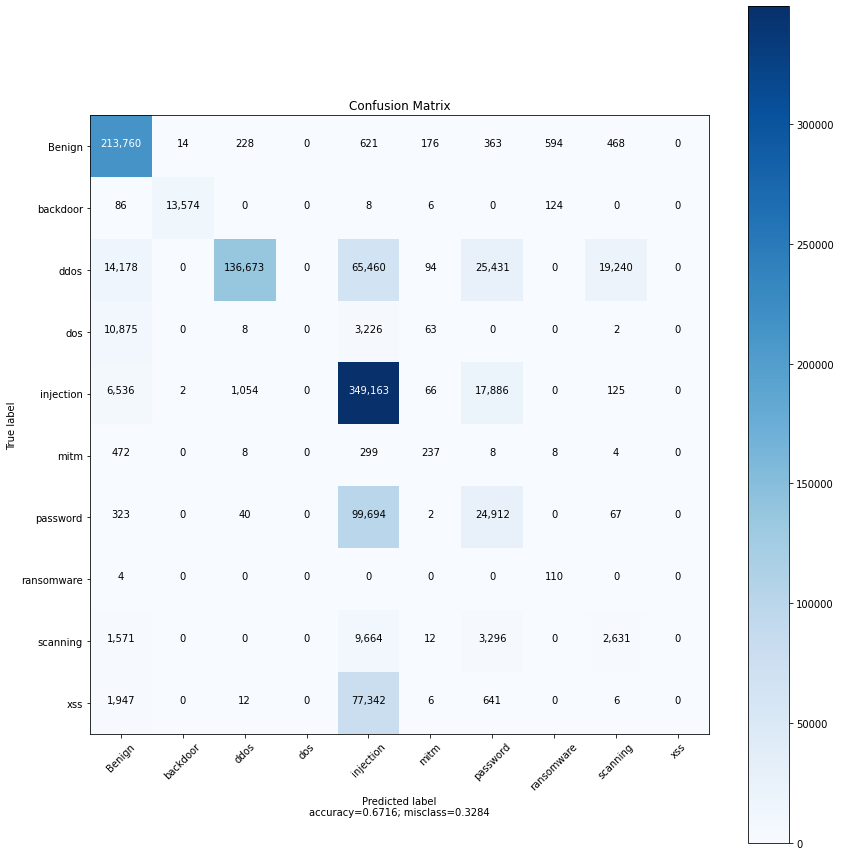

In [57]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [58]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign     0.8559    0.9886    0.9175    216224
    backdoor     0.9988    0.9838    0.9912     13798
        ddos     0.9902    0.5235    0.6849    261076
         dos     0.0000    0.0000    0.0000     14174
   injection     0.5767    0.9315    0.7124    374832
        mitm     0.3580    0.2288    0.2792      1036
    password     0.3434    0.1992    0.2522    125038
  ransomware     0.1316    0.9649    0.2316       114
    scanning     0.1167    0.1532    0.1325     17174
         xss     0.0000    0.0000    0.0000     79954

    accuracy                         0.6716   1103420
   macro avg     0.4371    0.4973    0.4201   1103420
weighted avg     0.6515    0.6716    0.6271   1103420



In [59]:
from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=2))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.86      0.99      0.92    216224
    backdoor       1.00      0.98      0.99     13798
        ddos       0.99      0.52      0.68    261076
         dos       0.00      0.00      0.00     14174
   injection       0.58      0.93      0.71    374832
        mitm       0.36      0.23      0.28      1036
    password       0.34      0.20      0.25    125038
  ransomware       0.13      0.96      0.23       114
    scanning       0.12      0.15      0.13     17174
         xss       0.00      0.00      0.00     79954

    accuracy                           0.67   1103420
   macro avg       0.44      0.50      0.42   1103420
weighted avg       0.65      0.67      0.63   1103420



In [60]:
th.save(model.state_dict(), 'unsw_ton_iot_multiclass_mean_agg.pt')